In [1]:
from itertools import product
from functools import partial
from pathlib import Path

from sklearn.model_selection import train_test_split

from imports_paper_plots import *

from echoes import ESNRegressor

from bioRNN.tasks.memory.capacity import make_X_y, forgetting
from bioRNN.utils import make_bioRRNs

set_context_and_font()
set_rcParams_color()

In [2]:
results_path = Path(os.environ["DATAICNS"])/"bioRNN/memory-capacity/reservoir-size-scaling"
results_path

Path('//mnt/91114856-a405-4086-bfbb-6c0bb5854f13/fdamicel/data/icns/bioRNN/memory-capacity/reservoir-size-scaling')

In [3]:
figs_path = Path(os.environ["DATAICNS"])/"bioRNN"/"figs"/"reservoir-scaling"

In [4]:
%%time
connectome_names = ["macaque", "marmoset", "human"]
neuron_densities = range(1, 31)

network_size = []
connectome = []
neuron_density_lst = []
for connectome_name, neuron_density in product(connectome_names, neuron_densities):
    Ws = make_bioRRNs(connectome_name=connectome_name,
                      neuron_density=neuron_density,
                      rand_partition=True)
    network_size.append(list(Ws.values())[0].shape[0])
    connectome.append(connectome_name)
    neuron_density_lst.append(neuron_density)

CPU times: user 1min 56s, sys: 4.38 s, total: 2min
Wall time: 1min 14s


In [5]:
density_df = pd.DataFrame({
    "Connectome": connectome,
    "neuron_density": neuron_density_lst,
    "network_size": network_size,
})
density_df.head()

,Connectome,neuron_density,network_size
0,macaque,1,29
1,macaque,2,58
2,macaque,3,87
3,macaque,4,116
4,macaque,5,145


In [6]:
density_df.network_size.unique()

array([  29,   58,   87,  116,  145,  174,  203,  232,  261,  290,  319,
        348,  377,  406,  435,  464,  493,  522,  551,  580,  609,  638,
        667,  696,  725,  754,  783,  812,  841,  870,   55,  110,  165,
        220,  275,  330,  385,  440,  495,  550,  605,  660,  715,  770,
        825,  880,  935,  990, 1045, 1100, 1155, 1210, 1265, 1320, 1375,
       1430, 1485, 1540, 1595, 1650,   57,  114,  171,  228,  285,  342,
        399,  456,  513,  570,  627,  684,  741,  798,  855,  912,  969,
       1026, 1083, 1140, 1197, 1254, 1311, 1368, 1425, 1482, 1539, 1596,
       1653, 1710])

Load results from task evaluations

In [7]:
results = pd.concat([
    pd.read_csv(results_path/fname)
    for fname in os.listdir(results_path)
])
print(results.shape)
results.head()

(86800, 9)


,connectome,rand_partition,neuron_density,W,bias,input_scaling,n_transient,spectral_radius,mean_test_memory_capacity
0,macaque,True,18,bio_rank,1,0.00001,100,0.99,26.037904
1,macaque,True,18,bio_norank,1,0.00001,100,0.99,25.797279
2,macaque,True,18,rnd_density,1,0.00001,100,0.99,25.690726
3,macaque,True,18,rnd_k,1,0.00001,100,0.99,25.991217
4,macaque,True,18,rnd_full,1,0.00001,100,0.99,27.866176


In [8]:
results.connectome.unique()

array(['macaque', 'marmoset', 'human'], dtype=object)

In [9]:
results = results.rename(columns={"mean_test_memory_capacity": "MC",
                                  "connectome": "Connectome"})

In [10]:
results = pd.merge(results, density_df, how="left")

In [11]:
results.head()

,Connectome,rand_partition,neuron_density,W,bias,input_scaling,n_transient,spectral_radius,MC,network_size
0,macaque,True,18,bio_rank,1,0.00001,100,0.99,26.037904,522
1,macaque,True,18,bio_norank,1,0.00001,100,0.99,25.797279,522
2,macaque,True,18,rnd_density,1,0.00001,100,0.99,25.690726,522
3,macaque,True,18,rnd_k,1,0.00001,100,0.99,25.991217,522
4,macaque,True,18,rnd_full,1,0.00001,100,0.99,27.866176,522


In [12]:
results = refactor_names(df=results, capitalize_cols=["Connectome"])
results.head()

,Connectome,rand_partition,neuron_density,W,bias,input_scaling,n_transient,spectral_radius,MC,network_size
0,Macaque,True,18,Bio (rank),1,0.00001,100,0.99,26.037904,522
1,Macaque,True,18,Bio (no-rank),1,0.00001,100,0.99,25.797279,522
2,Macaque,True,18,Random (density),1,0.00001,100,0.99,25.690726,522
3,Macaque,True,18,Random (k),1,0.00001,100,0.99,25.991217,522
4,Macaque,True,18,Random (full),1,0.00001,100,0.99,27.866176,522


In [22]:
palette = sns.color_palette(sns.color_palette()[-3:])
palette

[(0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

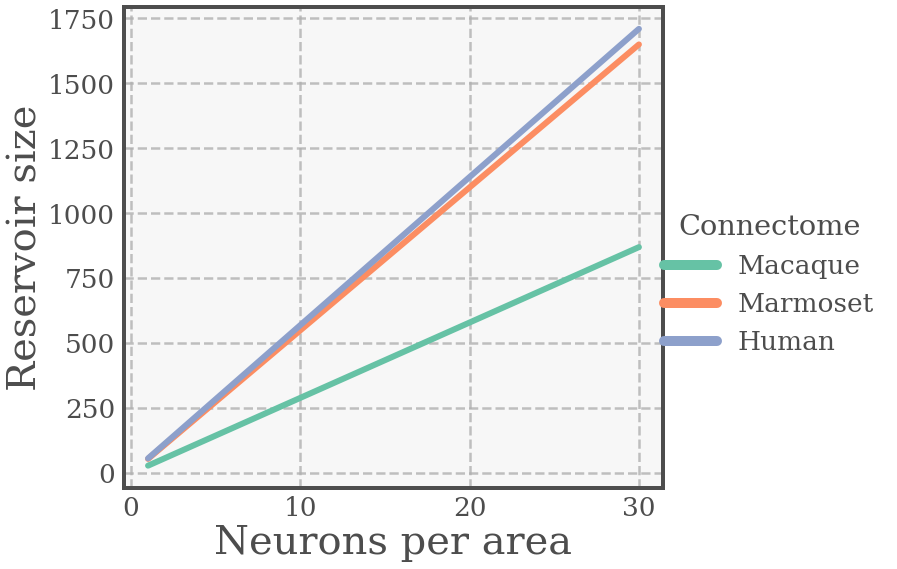

In [24]:
g = sns.relplot(
    x="neuron_density",
    y="network_size", 
    hue="Connectome", 
    kind="line",
    data=results,
    linewidth=6, 
    height=8,
    aspect=1.2,
    palette="Set2",
    #legend_out=True,
)
g.set_axis_labels(y_var=r"Reservoir size",
                  x_var=r"Neurons per area",
                  fontsize=40)
set_facetgrid_titles(g, col_template='{col_name}',size=50, row_template="{row_name}"), 
plt.setp(g._legend.get_lines(), linewidth=10)
tweak_axes(g.axes, grid_color="#b0b0b0")
plt.savefig(figs_path/"size_vs_density.svg")

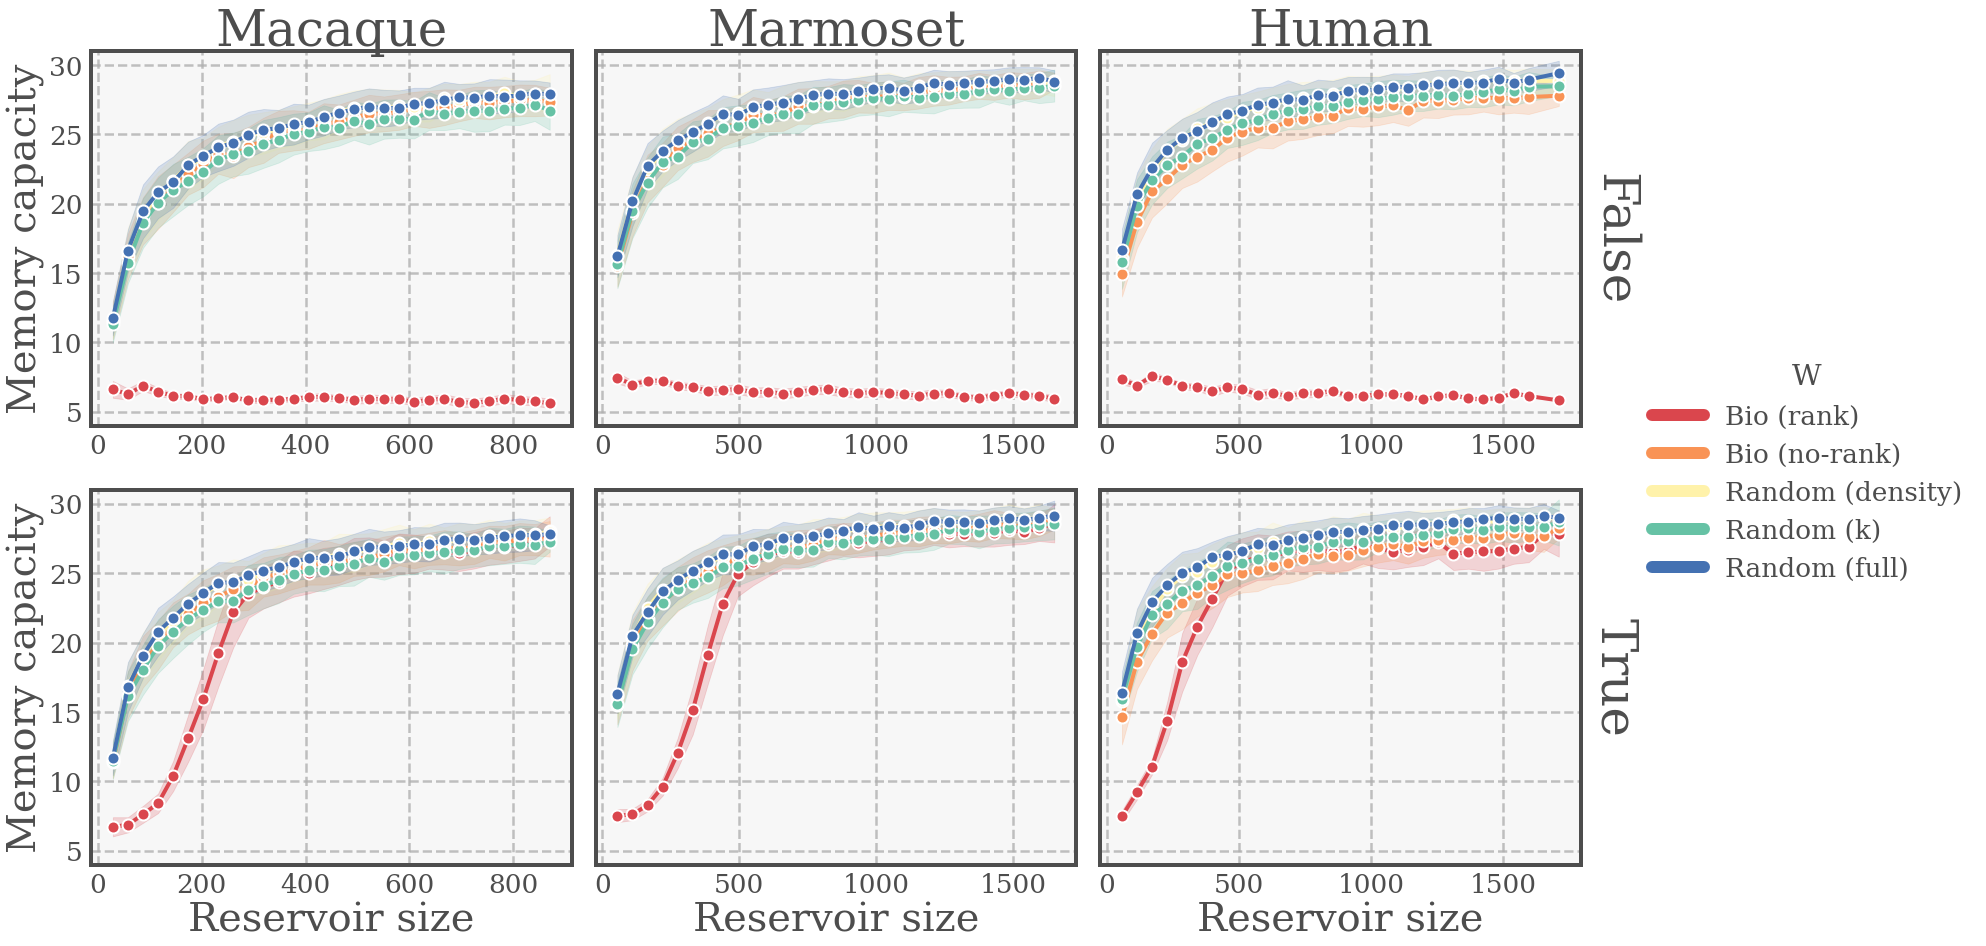

In [66]:
g = sns.relplot(
    x="network_size",
    y="MC",
    hue="W",
    kind="line",
    col="Connectome",
    row="rand_partition",
    data=results,
    ci="sd",
    palette=my_palette,
    height=6.5,
    aspect=1.18,
    facet_kws={
        "margin_titles":True,
        "legend_out": True,        
        "ylim": (4, 31),
        "sharex": False
    },
    linewidth=4, 
    style="W",
    dashes=False,
    markers=["o"]*len(results.W.unique()),
    #markeredgecolor="white",
    markersize=12,
    markeredgewidth=2.,
)

g.set_axis_labels(y_var=r"Memory capacity",
                  x_var=r"Reservoir size",
                  fontsize=40)
#g.set_xlabels(fontsize=30)
#g.set_ylabels(fontsize=30)
g.fig.subplots_adjust(wspace=0.05,)
set_facetgrid_titles(g, col_template='{col_name}',size=50, row_template="{row_name}"), 
plt.setp(g._legend.get_lines(), linewidth=12)
tweak_axes(g.axes, grid_color="#b0b0b0")
plt.savefig(figs_path/"memo-capacity_vs_reservoir-size.svg")